# Numerical precision

In general, we recommend setting JAX to double precision when working with jaxoplanet light curve functions

In [1]:
import jax

jax.config.update("jax_enable_x64", True)

Then, either to deal with very-precise datasets or for the sake of performance, users may want to adapt the precision of the light curve model. This can be done by changing the `order` parameter in most `light_curve` functions, which controls the number of points used for numerical integration.

## Limb darkened light curve

To demonstrate that, let's first compute a light curve at low order

In [2]:
from jaxoplanet.core.limb_dark import light_curve as light_curve

r = 1.0
b = 1.0
u = (1.0, 1.0)

calc = light_curve(u, b, r, order=10)

The simplest way to estimate the precision of this value is to compare it with one computed at large order

In [3]:
reference = light_curve(u, b, r, order=1500)

print(f"precision: {abs(calc-reference):.2e}")

precision: 1.08e-06


We can extend this approach further by computing the absolute error depending on the order of the numerical integration and the radius of the occultor

In [4]:
import jax.numpy as jnp


def estimate_precision(r=0.1):
    # values of b for which we expect the maximum error
    b = r if r > 1 else 1.0
    reference = light_curve(u, b, r, order=1500)

    def fun(order):
        calc = light_curve(u, b, r, order=order)
        result = jnp.abs(reference - calc)
        return max(result, 1e-16)

    return fun


orders = jnp.logspace(jnp.log10(5), jnp.log10(1000), 6).astype(int).tolist()

radii = [0.01, 0.1, 1.0]
with jax.disable_jit():
    precision = {r: [estimate_precision(r)(order) for order in orders] for r in radii}

And plot the results to identify an appropriate order for a given application

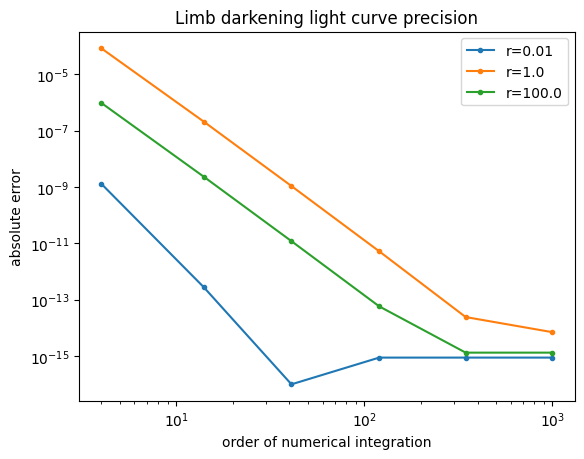

In [5]:
import matplotlib.pyplot as plt

for i, r in enumerate(radii):
    plt.plot(orders, precision[r], ".-", label=f"r={r}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("order of numerical integration")
plt.ylabel("absolute error")
plt.title("Limb darkening light curve precision")
_ = plt.legend()

```{note}
When setting the `order` parameter, keep in mind that the lower the order of the numerical integration, the faster the evaluation of the light curve function.
```

## Starry light curve

The same thing can be done for starry light curves, but using the `surface_light_curve function`

In [10]:
from jaxoplanet.starry import Surface, Ylm
from jaxoplanet.starry.light_curves import surface_light_curve

# degree of the spherical harmonics map
l_max = 3

# a dummy surface described by unitary coefficients (not physical)
y = Ylm.from_dense(jnp.ones((l_max + 1) ** 2))
surface = Surface(y=y, u=(1.0, 1.0))

r = 1.0
b = 1.0

reference = surface_light_curve(surface=surface, y=b, r=r, z=1.0, order=1500)
calc = surface_light_curve(surface=surface, y=b, r=r, z=1.0, order=10)

print(f"precision: {abs(calc-reference):.2e}")

precision: 5.48e-05


And as before

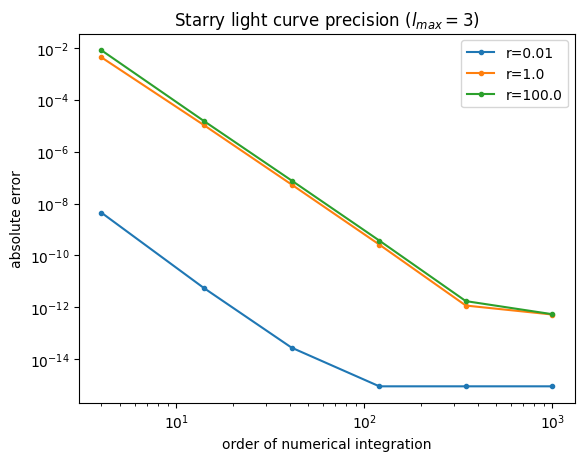

In [11]:
def estimate_precision(r=0.1):
    # values of b for which we expect the maximum error
    b = r if r > 1 else 1.0
    reference = surface_light_curve(surface=surface, y=b, r=r, z=1.0, order=1500)

    def fun(order):
        calc = surface_light_curve(surface=surface, y=b, r=r, z=1.0, order=order)
        result = jnp.abs(reference - calc)
        return max(result, 1e-16)

    return fun


with jax.disable_jit():
    precision = {r: [estimate_precision(r)(order) for order in orders] for r in radii}

for i, r in enumerate(radii):
    plt.plot(orders, precision[r], ".-", label=f"r={r}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("order of numerical integration")
plt.ylabel("absolute error")
plt.title(f"Starry light curve precision ($l_{{max}}={l_max}$)")
_ = plt.legend()